In [1]:
import scanpy as sc
import pytransform

## Data Loading
I am using the PBMC 3K dataset from 10x genomics. This dataset consists of 3000 peripheral blood mononuclear cells (PBMCs). PBMCs concist of mononucleated circulating cells. These include T cells, B Cells, NK Cells, and  monocytes. This dataset should be small enough to run on any standard laptop. It can be obtained [here](https://www.10xgenomics.com/resources/datasets/3-k-pbm-cs-from-a-healthy-donor-1-standard-1-1-0).

In [2]:
adata = sc.read_10x_mtx("hg19")

In [3]:
adata.var_names_make_unique()

## Preprocessing
Here we eliminate low quality cells, lowly expressed genes, etc.

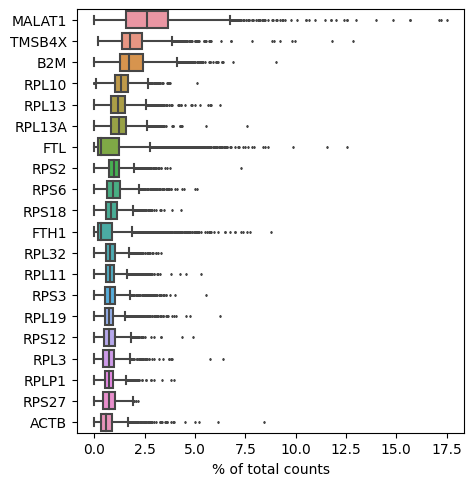

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

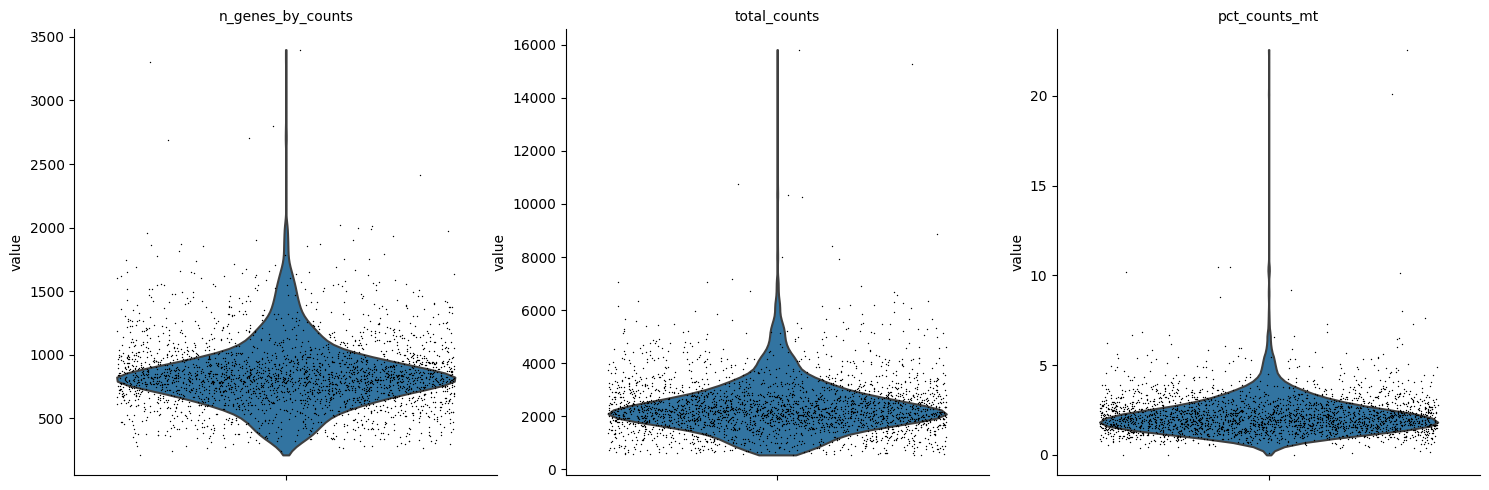

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

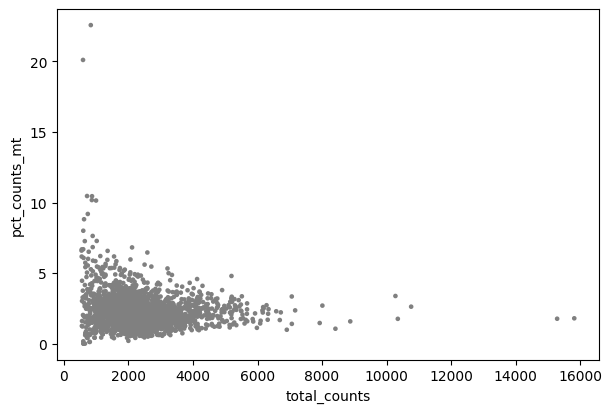

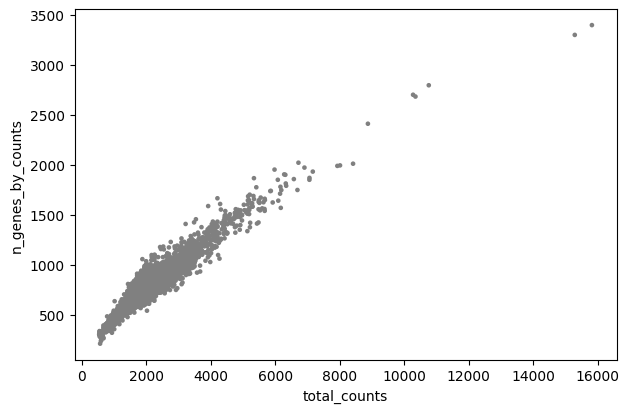

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [9]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

## Normalizing
Here we compare standard count based methods to pytransform

In [10]:
adata_logtransform = adata.copy() ## make a copy for log transforming

In [11]:
sc.pp.normalize_total(adata_logtransform, target_sum=1e4)
sc.pp.log1p(adata_logtransform)
sc.pp.highly_variable_genes(adata_logtransform, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_logtransform.raw = adata_logtransform
adata_logtransform = adata_logtransform[:, adata_logtransform.var["highly_variable"]]
sc.pp.regress_out(adata_logtransform, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_logtransform, max_value=10)

In [12]:
pytransform.pytransform(adata)


C:\Users\Alexe\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
C:\Users\Alexe\AppData\Local\Programs\Python\Python310\lib\site-packages\pytransform.py:147: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  anndata.var["coef"] = coefficient
C:\Users\Alexe\AppData\Local\Programs\Python\Python310\lib\site-packages\pytransform.py:191: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  anndata.var["Pearson_variance"] = pearson_var.flatten()


In [13]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.tl.pca(adata_logtransform, svd_solver='arpack')

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(adata_logtransform, n_neighbors=10, n_pcs=40)

C:\Users\Alexe\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Alexe\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Alexe\AppData\Local\Programs\Python\Python3

In [16]:
sc.tl.umap(adata)
sc.tl.umap(adata_logtransform)


Here we can see that the pytransform implementation performs the general structure of the data that is seen within log transforming. Additionally, we see unique clustering for a small subset of cells., as well as cleaner groupings.

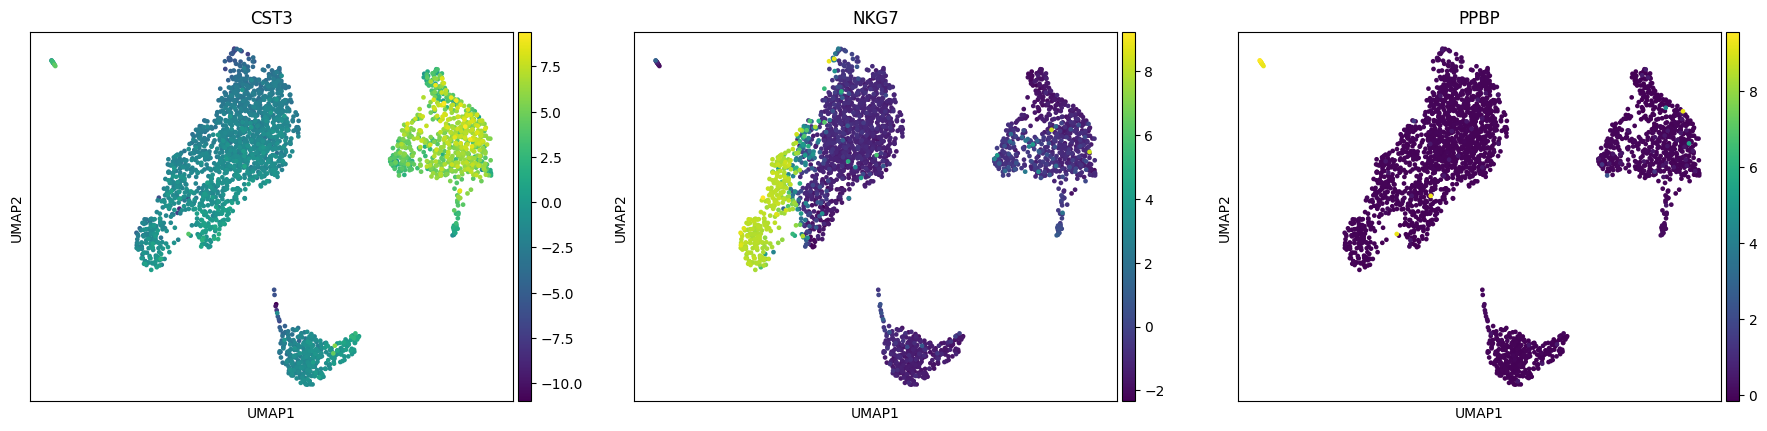

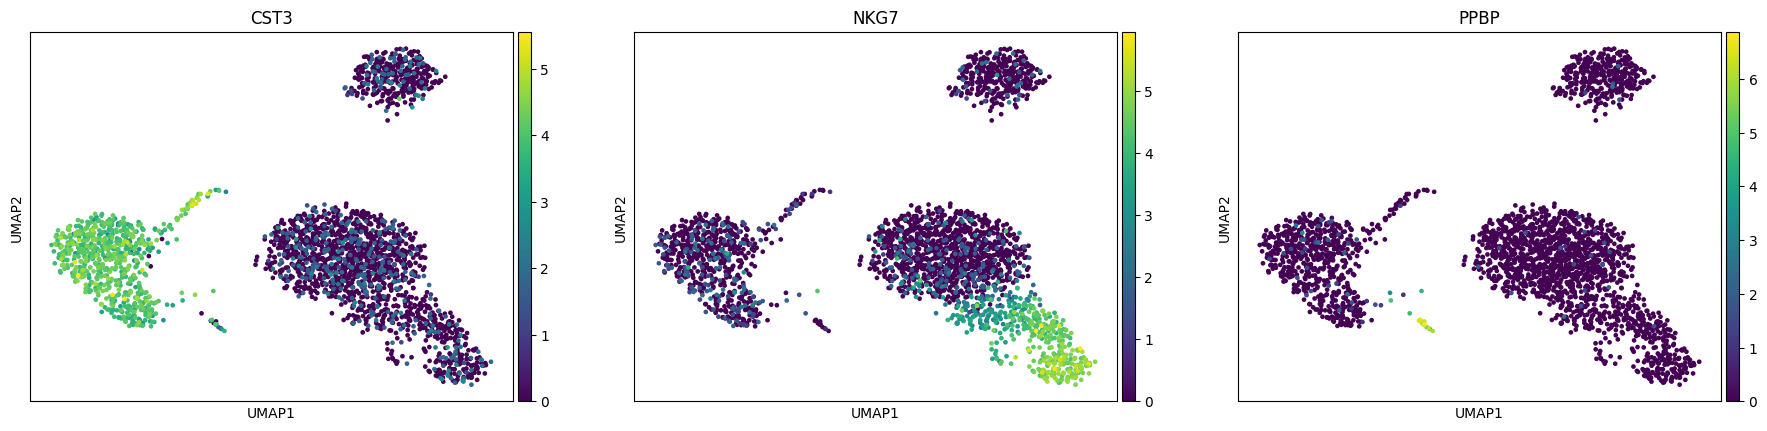

In [20]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])
sc.pl.umap(adata_logtransform, color=['CST3', 'NKG7', 'PPBP'])